## Result: Using the model to map drugs to their effect on the phenome 
As before, load in the data

In [1]:
outfile='testdir/testfiles'
pfile='data_for_regression/multixcan_res_10027.txt'
dfile='data_for_regression/epa.txt'
yfile='data_for_regression/sider_y.txt'
usfile='data_for_regression/US.txt'
ufile='data_for_regression/U.txt'
test='test'
sys.path.append("code/")
import setup_data
P, Ymat, Yalign, US, U, UB, SB, VB, make_L = setup_data.setup(pfile, yfile, dfile, usfile, ufile, False)

usfile is  data_for_regression/US.txt


In [9]:
### load in EPA and make it into a matrix
epa = pd.read_table("intermediate_files/epa_compiled.txt.gz",sep="\t",index_col=0)
xstk = epa.loc[:,['cid','aenm','hit_pct']].set_index(['cid','aenm']).sort_index().transpose().stack('aenm')
#xstk = xstk.droplevel(0,0)
xstk.index = xstk.index.droplevel(0)
col = xstk.columns


In [11]:
epa.shape

(134985, 9)

In [10]:
xstk.shape

(1391, 429)

Load in the projection $ U_DS_DW_{DP}$
Also create $U_DS_D\tilde{W}_{DP}$ (shuffled W projections, with regular drug data. Note this is just one single random shuffling of $W_{DP}$ for comparison.

In [2]:
result_files = 'results/indications'
U_DS_DdotW = setup_data.load_W_project(result_files+ "_W.txt", US)


U_DS_DdotW_scramble = setup_data.load_W_project(result_files + "_W.txt", US, scramble= True)


In [1]:
import pandas as pd
x = pd.read_table("results/indications_W.txt",sep="\t")

In [2]:
x.shape

(95, 131)

Note that the above code creates a projection using a random scrambled W so results vary slightly. To get exactly the result in this page, you can load in the particular one created here. 

In [3]:
#U_DS_DdotW_scramble.to_csv("figs/fig2_scrambW_example.txt.gz",sep="\t")
U_DS_DdotW_scramble = pd.read_csv("figs/fig2_scrambW_example.txt.gz",sep="\t",index_col=0)

In [4]:
import setup_data

In [5]:
from my_util import upper_tri

In [6]:
drug_phenome_distances = upper_tri(U_DS_DdotW.transpose().corr(method='spearman')) 
drug_scr_distances = upper_tri(U_DS_DdotW_scramble.transpose().corr(method='spearman')) 

In [7]:
from target_vs_null_projection_fig import *

## Fig 2B

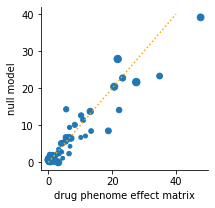

In [12]:
[t2d_db, d2t_db] = pickle.load( open("input_data/drugbank_merge_identicaltarget.pkl",'rb'))
r_inout_db = target_pairwise_in_vs_out(drug_phenome_distances, t2d_db, d2t_db)
s_inout_db = target_pairwise_in_vs_out(drug_scr_distances, t2d_db, d2t_db)


df_inout = pd.DataFrame({'r':-1*np.log10(r_inout_db['p']), 's':-1*np.log10(s_inout_db['p']), 'n':r_inout_db['n']})
f,ax=plt.subplots(1,figsize=(3,3))
ax.scatter(df_inout['r'],df_inout['s'],s=2*df_inout['n'])
ax.plot([0,40],[0,40],":",color='orange')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("drug phenome effect matrix")
ax.set_ylabel("null model")
#sel = df_inout.loc[df_inout['r'] > 3,:].index
#for targ in sel:
#    ax.text(df_inout.loc[targ,'r'], df_inout.loc[targ,'s'], targ)
f.savefig("fig2B.tiff",bbox_inches='tight',dpi=300)

## Fig 2C

In [12]:
d2tt = pickle.load(open("input_data/drug_target_small.pkl",'rb'))

tt2d = {t:[k for k,v in d2tt.items() if t in v] 
         for t in set(chain.from_iterable(d2tt.values()))}


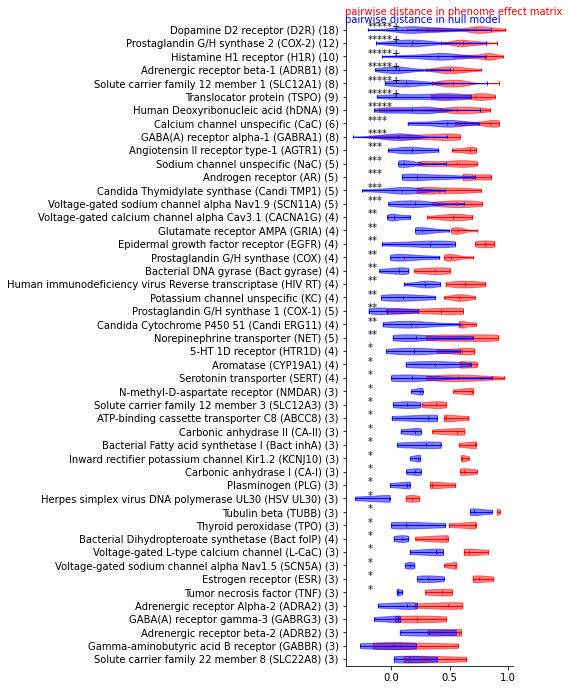

In [18]:
violin_per_target(tt2d, 12, drug_phenome_distances, drug_scr_distances)

Below is an alternate version of fig2c that uses Drugbank instead of the TTD to identify drug targets. The overall result is similar.

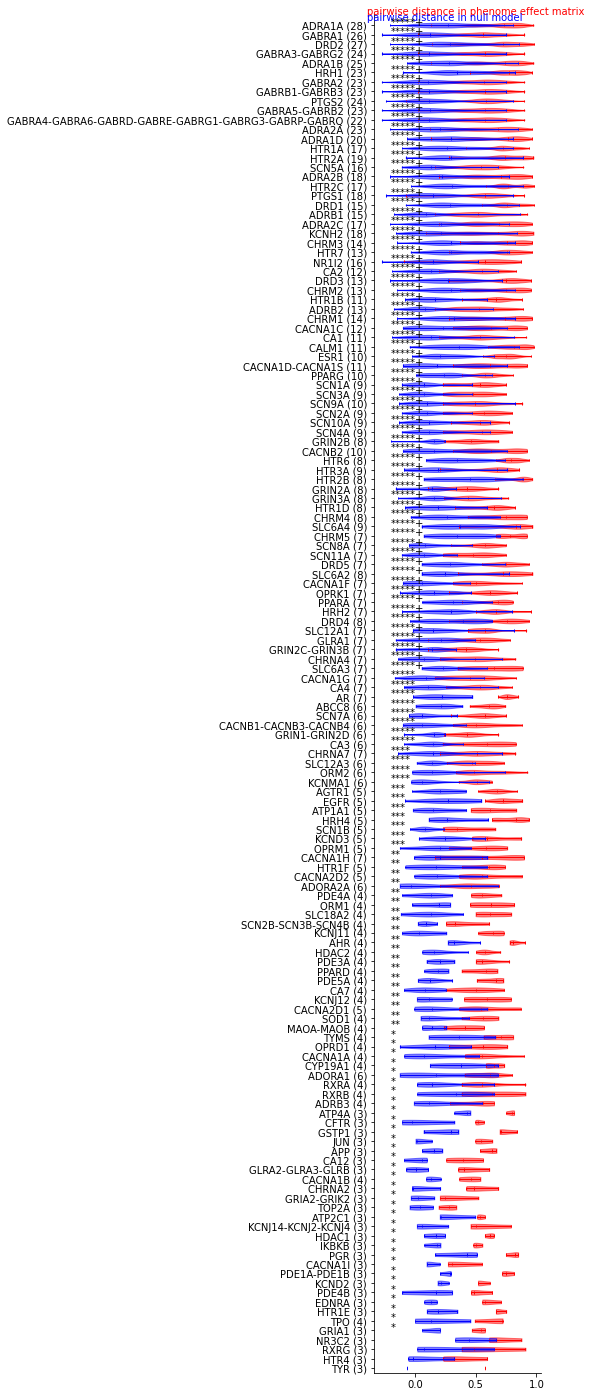

In [25]:
violin_per_target(t2d_db, 25, drug_phenome_distances, drug_scr_distances)

In [13]:
t2drugs = {t:[k for k,v in epa2targets.items() if t in v] 
         for t in set(chain.from_iterable(epa2targets.values()))}


In [4]:
D = pd.read_csv(dfile,sep="\t",index_col=0,nrows=2).columns

In [21]:
d2gene = {id2name[k]:[target_gene[t] for t in v ] for k,v in epa2targets.items() }

t2drugs = {t:[k for k,v in d2gene.items() if t in v] 
         for t in set(chain.from_iterable(d2gene.values()))}


NameError: name 'target_gene' is not defined

In [6]:
id2name, name2id = setup_data.get_id2name()

In [12]:
d2t = pd.read_csv("input_data/P1-07-Drug-TargetMapping.csv",skiprows=0,sep=",")
x = d2t.groupby('DrugID')['TargetID'].agg(list).to_dict()
ttd2cid = pd.read_csv("input_data/P1-03-TTD_crossmatching.txt",sep="\t",dtype=str,header=None)
ttd2cid = ttd2cid.loc[ttd2cid[1]=='PUBCHCID',:]
cid2ttd = ttd2cid.set_index(2)[0].to_dict()
cid2targets = {c:x[v] if v in x else [] for c,v in cid2ttd.items() }
epa2targets = {id2name[e]:cid2targets[e] if e in cid2targets else [] for e in D}